In [1]:
import numpy as np
%matplotlib inline
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor

In [2]:
# This program plots an event-level variable (MET) based on conditionals with its associated Jet arrays (in this case, where at least 2 have pT > 40)

class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "")
        MET_axis = hist.Bin("MET_pt", "MET [GeV]", 50, 0, 125)
        
        self._accumulator = processor.dict_accumulator({
            'MET_pt': hist.Hist("Counts", dataset_axis, MET_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        
        dataset = events.metadata["dataset"]
        
        jets = events.Jet
        MET = events.MET.pt
        
        output['cutflow']['all events'] += jets.size
        
        # We want jets with a pt of at least 40.
        pt_min = (jets.pt > 40)

        # We want MET where the above condition is met for at least two jets. The above is a list of Boolean sublists generated from the jet sublists (True if condition met, False if not). If we sum each sublist, we get the amount of jets matching the condition (since True = 1).
        good_MET = MET[(pt_min.sum() >= 2)]
        output['cutflow']['final events'] += good_MET.size
        
        output['MET_pt'].fill(dataset=dataset, MET_pt=good_MET)
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
fileset = {'SingleMu': ["data/Run2012B_SingleMu.root"]}
output = processor.run_uproot_job(fileset,
                                 treename='Events',
                                 processor_instance=Processor(),
                                 executor=processor.futures_executor,
                                 executor_args={'workers':4, 'nano': True},
                                 chunksize = 250000)

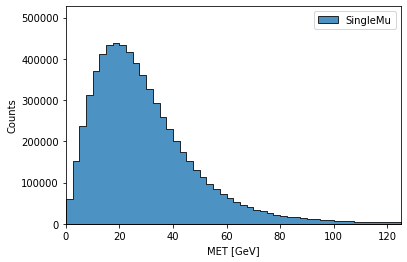

In [4]:
hist.plot1d(output['MET_pt'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [5]:
for key, value in output['cutflow'].items():
    print(key, value)

all events 53446198
final events 6665702
